# Statistical model
1. Single LinReg
2. One LinReg per model
3. One LinReg per model but include operators in training data.

In [1]:
# Load data
from src.util import read_results
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from src.util import model_operators, train_and_score, train_test_validate_split, feature_transform_pipe, eval_result
import numpy as np
result_df = read_results(from_parquet=True)
result_df.head()
%load_ext autoreload
%autoreload 2
plt.style.use("/home/pepijn/Documents/uni/y5/thesis/writing/msc-thesis-figures/std-colors.mplstyle")

from src.util import all_cat_features
list_features = [x for x in result_df.columns if isinstance(result_df[x].iloc[0], np.ndarray)]
print(list_features)
result_df = result_df.drop(columns=list_features)
cat_features = list(set(result_df.columns).intersection(all_cat_features))
result_df[cat_features] = result_df[cat_features].astype(str)

train, test, validate = train_test_validate_split(result_df)
estimator_results = {}

['features', 'r_S', 'c_S', 'nnz_S', 'sparsity_S', 'morpheusfi_eis', 'morpheusfi_nis']
train set:
	Records: 210953
	Positive (speedup > 1 with factorizing)/Negative: 39406/171547 = 0.23 s
	Dataset types: ['synthetic' 'hamlet']
\Compute Units: ['CPU 32c' '1080' 'CPU 16c' 'CPU 08c' 'v100' '2080' 'a40' 'p100']
test set:
	Records: 90409
	Positive (speedup > 1 with factorizing)/Negative: 17014/73395 = 0.23 s
	Dataset types: ['synthetic' 'hamlet']
\Compute Units: ['2080' '1080' 'CPU 16c' 'a40' 'v100' 'CPU 08c' 'CPU 32c' 'p100']
validate set:
	Records: 11187
	Positive (speedup > 1 with factorizing)/Negative: 1123/10064 = 0.11 s
	Dataset types: ['synthetic' 'hamlet' 'tpc_ai']
\Compute Units: ['p100' 'CPU 32c' 'CPU 16c' 'CPU 08c' '2080' '1080' 'v100' 'a40']


## Stat.1 Single LinReg


In [2]:
all_features = ['speedup', 'operator', 'num_cores', 'selectivity', 'cardinality_T',
       'cardinality_S', 'join', 'compute_unit', 'complexity_ratio',
       'times_mean', 'dataset_type', 'compute_type', 'label', 'features',
       'parallelism', 'mem_mat_read', 'mem_mat_write', 'mem_fac_read',
       'mem_fac_write', 'comp_scalar_mat', 'comp_lmm_mat', 'comp_rmm_mat',
       'comp_scalar_fac', 'comp_lmm_fac', 'comp_rmm_fac', 'comp_mat_col_major',
       'comp_fac_col_major', 'comp_scalar_dense', '13', '14',
       'comp_matrix_dense', 'mem_read_scalar_dense', 'mem_write_scalar_dense',
       'mem_read_matrix_dense', 'mem_write_matrix_dense', 'mem_read_rowsum',
       'mem_write_rowsum', 'mem_read_colsum', 'mem_write_colsum', '24', '25',
       'comp_rowsum', 'comp_colsum', 'comp_mat', 'comp_fac', 'comp_ratio',
       'tr', 'fr', 'r_S', 'c_S', 'TR', 'FR', 'nnz_T', 'nnz_S_sum', 'nnz_S',
       'r_T', 'c_T', 'sparsity_T', 'sparsity_S', 'morpheusfi_p',
       'morpheusfi_q', 'morpheusfi_eis', 'morpheusfi_ns', 'morpheusfi_nis',
       'gpu__architecture', 'gpu__number_of_sm', 'gpu__cores',
       'gpu_cache_size_l1', 'gpu_cache_size_l2', 'gpu_clock_speed_base',
       'gpu_clock_speed_max_boost', 'gpu_memory_bus_width', 'gpu_memory_size',
       'gpu_memory_clock', 'gpu_memory_bandwidth',
       'gpu_processing_power_half_precision',
       'gpu_processing_power_single_precision',
       'gpu_processing_power_double_precision', 'materialized_times_mean',
       'time_saved']
meta_features = ['dataset_type', 'features', 'comp_ratio', 'tr', 'fr', 'compute_unit', 'materialized_times_mean']
dep = ['speedup', 'times_mean', 'label', 'time_saved','materialized_times_mean']
indep = list(set(all_features).intersection(result_df.columns) - set(dep) - set(meta_features))

2024-03-24 21:33:30.270 | INFO     | src.util:feature_transform_pipe:435 - ['operator', 'compute_type', 'join', 'gpu__architecture']
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/amalur-factorization/venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/amalur-factorization/venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/amalur-factorization/venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
2024-03-24 21:33:39.211 | INFO     | src.util:eval_model:471 - Model <class 'sklearn.pipeline.Pipeline'>, 

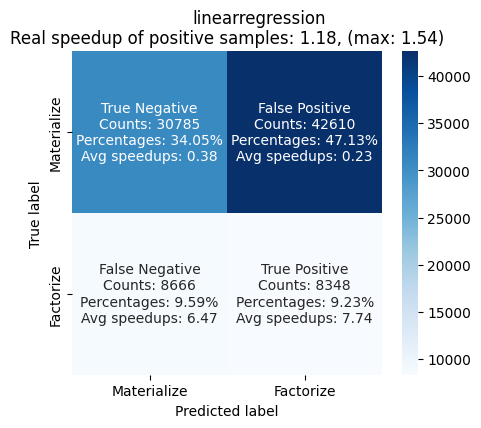

In [3]:
target_col = 'time_saved'
X_train, y_train = train[indep], train[target_col]
X_test, y_test = test[indep], test[target_col]
X_validate, y_validate = validate[indep], validate[target_col]

lin_reg_combined = train_and_score(LinearRegression(), X_train, X_test, y_train, y_test, full_dataset=test, fillna=True, target_col=target_col)

# Test only on models
locator = test[test.operator.isin(model_operators)].index
y_pred = pd.Series(lin_reg_combined.predict(X_test.loc[locator]), index=X_test.loc[locator].index)
resul = eval_result(y_test.loc[locator], y_pred > 1.2, full_dataset=test.loc[locator], model_name='STAT.1', target_col=target_col)

estimator_results['STAT.1'] = resul[0]

<Axes: xlabel='boundary', ylabel='y_pred_time_saved'>

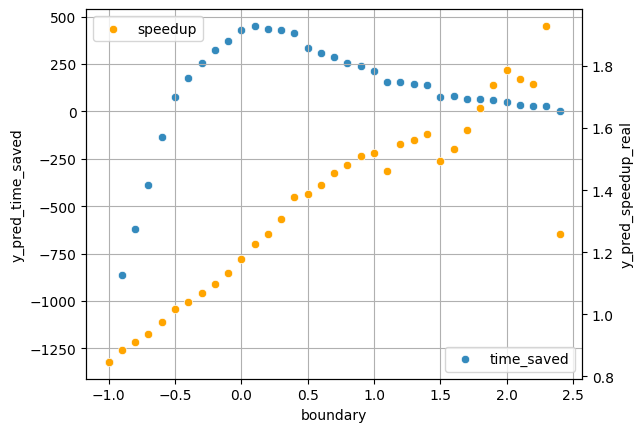

In [4]:
from src.util import eval_result

def plot_boundary(y_true, y_pred, lower=-1., upper=1., step=0.1, target_col=target_col):
    # Create a list to store the results
    results = []

    # Loop over the range of boundaries
    x= np.arange(lower, upper, step)
    for boundary in x:
        result = eval_result(y_true, y_pred = y_pred > boundary, full_dataset=test, target_col=target_col)
        results.append({'boundary': boundary, **result[2]})

    dd = pd.DataFrame(results)
    ax=sns.scatterplot(data=dd, x="boundary", y="y_pred_time_saved", label='time_saved')
    sns.scatterplot(data=dd, x="boundary", y="y_pred_speedup_real", ax=ax.twinx(), label='speedup', color='orange')
    ax.grid()
    ax.legend(loc='lower right')
    return ax
plot_boundary(y_test, pd.Series(lin_reg_combined.predict(X_test), index=X_test.index), upper=2.5, target_col=target_col)

## STAT.2 Single linreg on only Models

2024-03-24 21:33:46.876 | INFO     | src.util:feature_transform_pipe:435 - ['operator', 'compute_type', 'join', 'gpu__architecture']


train set:
	Records: 47254
	Positive (speedup > 1 with factorizing)/Negative: 3715/43539 = 0.09 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 16c' '1080' 'v100' 'CPU 32c' 'a40' '2080']
test set:
	Records: 20252
	Positive (speedup > 1 with factorizing)/Negative: 1562/18690 = 0.08 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 32c' 'CPU 16c' '1080' 'a40' '2080' 'v100']
validate set:
	Records: 11187
	Positive (speedup > 1 with factorizing)/Negative: 1123/10064 = 0.11 s
	Dataset types: ['synthetic' 'hamlet' 'tpc_ai']
\Compute Units: ['p100' 'CPU 32c' 'CPU 16c' 'CPU 08c' '2080' '1080' 'v100' 'a40']


/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/amalur-factorization/venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/amalur-factorization/venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/amalur-factorization/venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
2024-03-24 21:33:48.886 | INFO     | src.util:eval_model:471 - Model <class 'sklearn.pipeline.Pipeline'>, linearregression
 test cols: Index(['selectivity', 'comp_scalar_dense', 'c_T', 'mem_fac_write',
       'parallelism', 'mem_write_scal

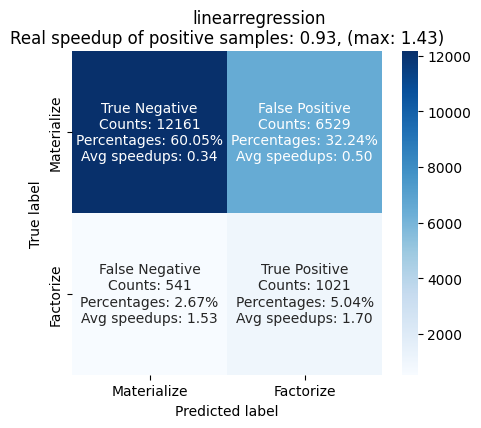

In [5]:
train, test, validate = train_test_validate_split(result_df[result_df.operator.isin(model_operators)])
X_train, y_train = train[indep], train[target_col]
X_test, y_test = test[indep], test[target_col]
X_validate, y_validate = validate[indep], validate[target_col]
lin_reg_model = train_and_score(LinearRegression(), X_train, X_test, y_train, y_test, full_dataset=test, fillna=True)

<Axes: xlabel='boundary', ylabel='y_pred_time_saved'>

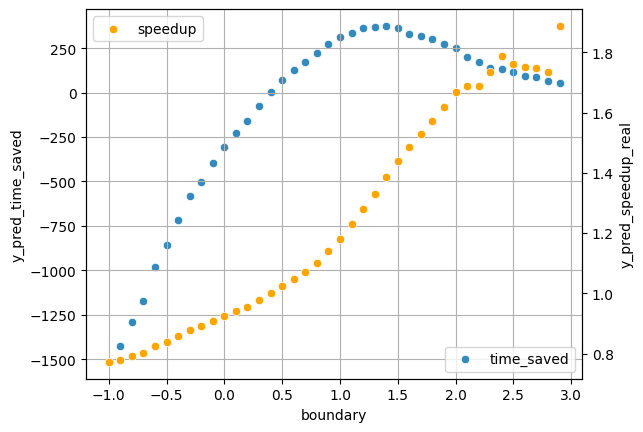

In [6]:
y_pred = pd.Series(lin_reg_model.predict(X_test), index=X_test.index)
plot_boundary(y_test, y_pred, upper=3.0)

In [7]:
estimator_results['STAT.2'] = eval_result(y_test, y_pred>1.5, full_dataset=test, model_name='STAT.2')[0]

## STAT.3 Linear Regression predict runtime for F & M
Two regression, predict runtime for both F and M. Select lowest

In [8]:
from src.analytical_model import create_linreg_ensemble, predict_linreg_ensemble


train, test, validate = train_test_validate_split(result_df[result_df.operator.isin(model_operators)])
# Add a constant column to the dataframes
train['constant'] = 1
test['constant'] = 1
validate['constant'] = 1

X_train, y_train = train[indep], train[["times_mean", "materialized_times_mean"]]
X_test, y_test = test[indep], test[["times_mean", "materialized_times_mean"]]
X_validate, y_validate = validate[indep], validate[["times_mean", "materialized_times_mean"]]

train set:
	Records: 47254
	Positive (speedup > 1 with factorizing)/Negative: 3715/43539 = 0.09 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 16c' '1080' 'v100' 'CPU 32c' 'a40' '2080']
test set:
	Records: 20252
	Positive (speedup > 1 with factorizing)/Negative: 1562/18690 = 0.08 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 32c' 'CPU 16c' '1080' 'a40' '2080' 'v100']
validate set:
	Records: 11187
	Positive (speedup > 1 with factorizing)/Negative: 1123/10064 = 0.11 s
	Dataset types: ['synthetic' 'hamlet' 'tpc_ai']
\Compute Units: ['p100' 'CPU 32c' 'CPU 16c' 'CPU 08c' '2080' '1080' 'v100' 'a40']


In [9]:
linreg_f_m = create_linreg_ensemble(
    train,
    X_train,
    y_train,
    clf_func=feature_transform_pipe,
    clf_kwargs=dict(model=LinearRegression, X_train=X_train, fillna=True),
    rfecv=False,
    split_by='constant',
)
pred = predict_linreg_ensemble(linreg_f_m, test, X_test, y_test.columns, split_by='constant')

2024-03-24 21:33:51.793 | INFO     | src.analytical_model:create_linreg_ensemble:102 - Creating a linear regression ensemble for the analytical model, splitting by constant
2024-03-24 21:33:51.805 | INFO     | src.util:feature_transform_pipe:435 - ['operator', 'compute_type', 'join', 'gpu__architecture']


2024-03-24 21:33:53.836 | INFO     | src.util:feature_transform_pipe:435 - ['operator', 'compute_type', 'join', 'gpu__architecture']
2024-03-24 21:33:55.786 | INFO     | src.analytical_model:create_linreg_ensemble:128 - Created a linear regression ensemble for the analytical model with 2 models
2024-03-24 21:33:55.790 | INFO     | src.analytical_model:predict_linreg_ensemble:71 - Predicting results of the analytical model using a linear regression ensemble


/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:489: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:489: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:489: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:489: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:489: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Do

<Axes: xlabel='boundary', ylabel='y_pred_time_saved'>

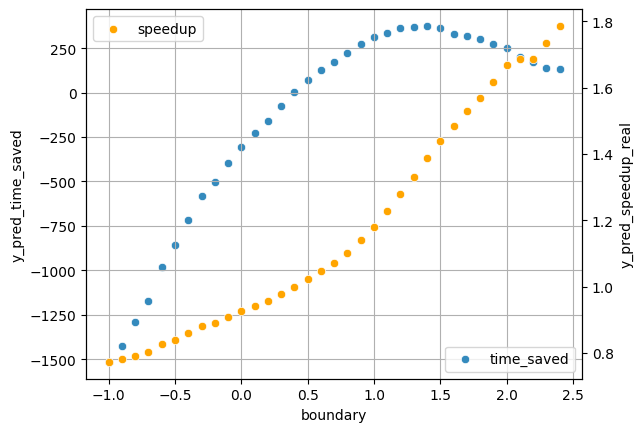

In [10]:
y_pred = (pred.materialized_times_mean - pred.times_mean)
plot_boundary((y_test.materialized_times_mean - y_test.times_mean), y_pred, upper=2.5)

In [11]:
res = eval_result((y_test.materialized_times_mean - y_test.times_mean), y_pred = y_pred > 1.4, full_dataset=test, target_col='time_saved')
estimator_results['STAT.3'] = res[0]

/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:489: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]


## Stat.4 Separate regressors for each model type

## Stat.4 Separate regressors for each model type

In [12]:
train, test, validate = train_test_validate_split(result_df[result_df.operator.isin(model_operators)])
X_train, y_train = train[indep], train["time_saved"]
X_test, y_test = test[indep], test["time_saved"]
X_validate, y_validate = validate[indep], validate["time_saved"]

linreg_f_m = create_linreg_ensemble(
    train,
    X_train,
    y_train,
    clf_func=feature_transform_pipe,
    clf_kwargs=dict(model=LinearRegression, X_train=X_train, fillna=True),
    rfecv=False,
    split_by='operator',
)
pred = predict_linreg_ensemble(linreg_f_m, test, X_test, [y_test.name], split_by='operator')

2024-03-24 21:33:59.635 | INFO     | src.analytical_model:create_linreg_ensemble:102 - Creating a linear regression ensemble for the analytical model, splitting by operator
2024-03-24 21:33:59.650 | INFO     | src.util:feature_transform_pipe:435 - ['operator', 'compute_type', 'join', 'gpu__architecture']


train set:
	Records: 47254
	Positive (speedup > 1 with factorizing)/Negative: 3715/43539 = 0.09 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 16c' '1080' 'v100' 'CPU 32c' 'a40' '2080']
test set:
	Records: 20252
	Positive (speedup > 1 with factorizing)/Negative: 1562/18690 = 0.08 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 32c' 'CPU 16c' '1080' 'a40' '2080' 'v100']
validate set:
	Records: 11187
	Positive (speedup > 1 with factorizing)/Negative: 1123/10064 = 0.11 s
	Dataset types: ['synthetic' 'hamlet' 'tpc_ai']
\Compute Units: ['p100' 'CPU 32c' 'CPU 16c' 'CPU 08c' '2080' '1080' 'v100' 'a40']


2024-03-24 21:34:00.765 | INFO     | src.util:feature_transform_pipe:435 - ['operator', 'compute_type', 'join', 'gpu__architecture']
2024-03-24 21:34:01.857 | INFO     | src.util:feature_transform_pipe:435 - ['operator', 'compute_type', 'join', 'gpu__architecture']
2024-03-24 21:34:02.986 | INFO     | src.util:feature_transform_pipe:435 - ['operator', 'compute_type', 'join', 'gpu__architecture']
2024-03-24 21:34:04.127 | INFO     | src.analytical_model:create_linreg_ensemble:128 - Created a linear regression ensemble for the analytical model with 4 models
2024-03-24 21:34:04.130 | INFO     | src.analytical_model:predict_linreg_ensemble:71 - Predicting results of the analytical model using a linear regression ensemble


In [13]:
res = eval_result(y_test, y_pred = pred.time_saved, full_dataset=test)
estimator_results['STAT.4'] = res[0]

/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:489: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]


## Stat. 5 split CPU and GPU

In [14]:
train, test, validate = train_test_validate_split(result_df[result_df.operator.isin(model_operators)])
X_train, y_train = train[indep], train["time_saved"]
X_test, y_test = test[indep], test["time_saved"]
X_validate, y_validate = validate[indep], validate["time_saved"]

split_by = 'compute_type'
linreg_f_m = create_linreg_ensemble(
    train,
    X_train,
    y_train,
    clf_func=feature_transform_pipe,
    clf_kwargs=dict(model=LinearRegression, X_train=X_train, fillna=True),
    rfecv=False,
    split_by=split_by,
)
pred = predict_linreg_ensemble(linreg_f_m, test, X_test, [y_test.name], split_by=split_by)

2024-03-24 21:34:04.799 | INFO     | src.analytical_model:create_linreg_ensemble:102 - Creating a linear regression ensemble for the analytical model, splitting by compute_type
2024-03-24 21:34:04.811 | INFO     | src.util:feature_transform_pipe:435 - ['operator', 'compute_type', 'join', 'gpu__architecture']


train set:
	Records: 47254
	Positive (speedup > 1 with factorizing)/Negative: 3715/43539 = 0.09 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 16c' '1080' 'v100' 'CPU 32c' 'a40' '2080']
test set:
	Records: 20252
	Positive (speedup > 1 with factorizing)/Negative: 1562/18690 = 0.08 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 32c' 'CPU 16c' '1080' 'a40' '2080' 'v100']
validate set:
	Records: 11187
	Positive (speedup > 1 with factorizing)/Negative: 1123/10064 = 0.11 s
	Dataset types: ['synthetic' 'hamlet' 'tpc_ai']
\Compute Units: ['p100' 'CPU 32c' 'CPU 16c' 'CPU 08c' '2080' '1080' 'v100' 'a40']


2024-03-24 21:34:06.063 | INFO     | src.util:feature_transform_pipe:435 - ['operator', 'compute_type', 'join', 'gpu__architecture']
2024-03-24 21:34:07.681 | INFO     | src.analytical_model:create_linreg_ensemble:128 - Created a linear regression ensemble for the analytical model with 2 models
2024-03-24 21:34:07.683 | INFO     | src.analytical_model:predict_linreg_ensemble:71 - Predicting results of the analytical model using a linear regression ensemble


/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:489: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:489: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:489: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:489: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:489: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Do

<Axes: xlabel='boundary', ylabel='y_pred_time_saved'>

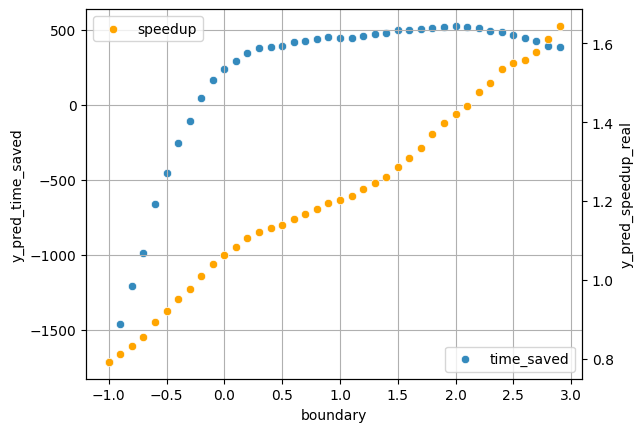

In [15]:
res = eval_result(y_test, y_pred = pred.time_saved > 0.7, full_dataset=test)
estimator_results['STAT.5'] = res[0]
res[0]
plot_boundary(y_test, pred.time_saved, upper=3.0)

## Stat.6 Split by F,M,operator

In [16]:
train, test, validate = train_test_validate_split(result_df[result_df.operator.isin(model_operators)])
X_train, y_train = train[indep], train[["times_mean", "materialized_times_mean"]]
X_test, y_test = test[indep], test[["times_mean", "materialized_times_mean"]]
X_validate, y_validate = validate[indep], validate[["times_mean", "materialized_times_mean"]]

split_by = ['operator']
linreg_f_m = create_linreg_ensemble(
    train,
    X_train,
    y_train,
    clf_func=feature_transform_pipe,
    clf_kwargs=dict(model=LinearRegression, X_train=X_train, fillna=True),
    rfecv=False,
    split_by=split_by,
)
pred = predict_linreg_ensemble(linreg_f_m, test, X_test, y_test.columns, split_by=split_by)

2024-03-24 21:34:11.716 | INFO     | src.analytical_model:create_linreg_ensemble:102 - Creating a linear regression ensemble for the analytical model, splitting by ['operator']
2024-03-24 21:34:11.738 | INFO     | src.util:feature_transform_pipe:435 - ['operator', 'compute_type', 'join', 'gpu__architecture']


train set:
	Records: 47254
	Positive (speedup > 1 with factorizing)/Negative: 3715/43539 = 0.09 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 16c' '1080' 'v100' 'CPU 32c' 'a40' '2080']
test set:
	Records: 20252
	Positive (speedup > 1 with factorizing)/Negative: 1562/18690 = 0.08 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 32c' 'CPU 16c' '1080' 'a40' '2080' 'v100']
validate set:
	Records: 11187
	Positive (speedup > 1 with factorizing)/Negative: 1123/10064 = 0.11 s
	Dataset types: ['synthetic' 'hamlet' 'tpc_ai']
\Compute Units: ['p100' 'CPU 32c' 'CPU 16c' 'CPU 08c' '2080' '1080' 'v100' 'a40']


2024-03-24 21:34:12.797 | INFO     | src.util:feature_transform_pipe:435 - ['operator', 'compute_type', 'join', 'gpu__architecture']
2024-03-24 21:34:13.859 | INFO     | src.util:feature_transform_pipe:435 - ['operator', 'compute_type', 'join', 'gpu__architecture']
2024-03-24 21:34:14.838 | INFO     | src.util:feature_transform_pipe:435 - ['operator', 'compute_type', 'join', 'gpu__architecture']
2024-03-24 21:34:15.851 | INFO     | src.util:feature_transform_pipe:435 - ['operator', 'compute_type', 'join', 'gpu__architecture']
2024-03-24 21:34:16.835 | INFO     | src.util:feature_transform_pipe:435 - ['operator', 'compute_type', 'join', 'gpu__architecture']
2024-03-24 21:34:17.836 | INFO     | src.util:feature_transform_pipe:435 - ['operator', 'compute_type', 'join', 'gpu__architecture']
2024-03-24 21:34:18.802 | INFO     | src.util:feature_transform_pipe:435 - ['operator', 'compute_type', 'join', 'gpu__architecture']
2024-03-24 21:34:19.748 | INFO     | src.analytical_model:create_linr

/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:489: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:489: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:489: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:489: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:489: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Do

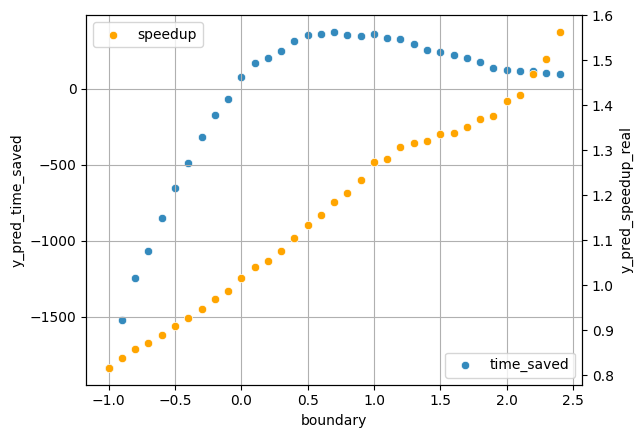

In [17]:
y_pred = (pred.materialized_times_mean - pred.times_mean)
plot_boundary((y_test.materialized_times_mean - y_test.times_mean), y_pred, upper=2.5)
res = eval_result((y_test.materialized_times_mean - y_test.times_mean), y_pred = y_pred > 0.6, full_dataset=test, target_col='time_saved')
estimator_results['STAT.6'] = res[0]

## Stat.7 Split by F,M,operator

In [26]:
train, test, validate = train_test_validate_split(result_df[result_df.operator.isin(model_operators)])
X_train, y_train = train[indep], train[["times_mean", "materialized_times_mean"]]
X_test, y_test = test[indep], test[["times_mean", "materialized_times_mean"]]
X_validate, y_validate = validate[indep], validate[["times_mean", "materialized_times_mean"]]

split_by = ['operator', 'compute_type']
stat7 = create_linreg_ensemble(
    train,
    X_train,
    y_train,
    clf_func=feature_transform_pipe,
    clf_kwargs=dict(model=LinearRegression, X_train=X_train, fillna=True),
    rfecv=False,
    split_by=split_by,
)
pred = predict_linreg_ensemble(stat7, test, X_test, y_test.columns, split_by=split_by)

import pickle
with open("trained_models/stat7.pkl", "wb") as f:
    pickle.dump(linreg_f_m, f)

2024-03-24 21:43:01.056 | INFO     | src.analytical_model:create_linreg_ensemble:102 - Creating a linear regression ensemble for the analytical model, splitting by ['operator', 'compute_type']
2024-03-24 21:43:01.073 | INFO     | src.util:feature_transform_pipe:435 - ['operator', 'compute_type', 'join', 'gpu__architecture']


train set:
	Records: 47254
	Positive (speedup > 1 with factorizing)/Negative: 3715/43539 = 0.09 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 16c' '1080' 'v100' 'CPU 32c' 'a40' '2080']
test set:
	Records: 20252
	Positive (speedup > 1 with factorizing)/Negative: 1562/18690 = 0.08 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 32c' 'CPU 16c' '1080' 'a40' '2080' 'v100']
validate set:
	Records: 11187
	Positive (speedup > 1 with factorizing)/Negative: 1123/10064 = 0.11 s
	Dataset types: ['synthetic' 'hamlet' 'tpc_ai']
\Compute Units: ['p100' 'CPU 32c' 'CPU 16c' 'CPU 08c' '2080' '1080' 'v100' 'a40']


2024-03-24 21:43:01.973 | INFO     | src.util:feature_transform_pipe:435 - ['operator', 'compute_type', 'join', 'gpu__architecture']
2024-03-24 21:43:02.868 | INFO     | src.util:feature_transform_pipe:435 - ['operator', 'compute_type', 'join', 'gpu__architecture']
2024-03-24 21:43:03.817 | INFO     | src.util:feature_transform_pipe:435 - ['operator', 'compute_type', 'join', 'gpu__architecture']
2024-03-24 21:43:04.752 | INFO     | src.util:feature_transform_pipe:435 - ['operator', 'compute_type', 'join', 'gpu__architecture']
2024-03-24 21:43:05.656 | INFO     | src.util:feature_transform_pipe:435 - ['operator', 'compute_type', 'join', 'gpu__architecture']
2024-03-24 21:43:06.555 | INFO     | src.util:feature_transform_pipe:435 - ['operator', 'compute_type', 'join', 'gpu__architecture']
2024-03-24 21:43:07.530 | INFO     | src.util:feature_transform_pipe:435 - ['operator', 'compute_type', 'join', 'gpu__architecture']
2024-03-24 21:43:08.463 | INFO     | src.util:feature_transform_pipe:

/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:489: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:489: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:489: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:489: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:489: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Do

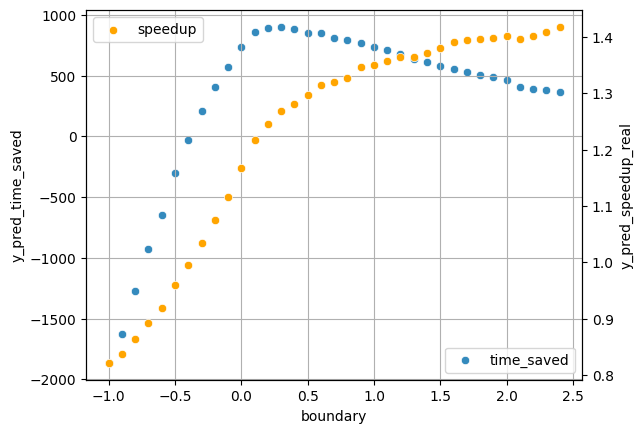

In [19]:
y_pred = (pred.materialized_times_mean - pred.times_mean)
plot_boundary((y_test.materialized_times_mean - y_test.times_mean), y_pred, upper=2.5)
res = eval_result((y_test.materialized_times_mean - y_test.times_mean), y_pred = y_pred > 0.2, full_dataset=test, target_col='time_saved')
estimator_results['STAT.7'] = res[0]

## STAT.8 (not included)

In [20]:
train, test, validate = train_test_validate_split(result_df[result_df.operator.isin(model_operators)])
X_train, y_train = train[indep], train[["times_mean", "materialized_times_mean"]]
X_test, y_test = test[indep], test[["times_mean", "materialized_times_mean"]]
X_validate, y_validate = validate[indep], validate[["times_mean", "materialized_times_mean"]]

split_by = ['compute_type']
linreg_f_m = create_linreg_ensemble(
    train,
    X_train,
    y_train,
    clf_func=feature_transform_pipe,
    clf_kwargs=dict(model=LinearRegression, X_train=X_train, fillna=True),
    rfecv=False,
    split_by=split_by,
)
pred = predict_linreg_ensemble(linreg_f_m, test, X_test, y_test.columns, split_by=split_by)

2024-03-24 21:34:43.040 | INFO     | src.analytical_model:create_linreg_ensemble:102 - Creating a linear regression ensemble for the analytical model, splitting by ['compute_type']
2024-03-24 21:34:43.053 | INFO     | src.util:feature_transform_pipe:435 - ['operator', 'compute_type', 'join', 'gpu__architecture']


train set:
	Records: 47254
	Positive (speedup > 1 with factorizing)/Negative: 3715/43539 = 0.09 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 16c' '1080' 'v100' 'CPU 32c' 'a40' '2080']
test set:
	Records: 20252
	Positive (speedup > 1 with factorizing)/Negative: 1562/18690 = 0.08 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 32c' 'CPU 16c' '1080' 'a40' '2080' 'v100']
validate set:
	Records: 11187
	Positive (speedup > 1 with factorizing)/Negative: 1123/10064 = 0.11 s
	Dataset types: ['synthetic' 'hamlet' 'tpc_ai']
\Compute Units: ['p100' 'CPU 32c' 'CPU 16c' 'CPU 08c' '2080' '1080' 'v100' 'a40']


2024-03-24 21:34:44.245 | INFO     | src.util:feature_transform_pipe:435 - ['operator', 'compute_type', 'join', 'gpu__architecture']
2024-03-24 21:34:45.639 | INFO     | src.util:feature_transform_pipe:435 - ['operator', 'compute_type', 'join', 'gpu__architecture']
2024-03-24 21:34:47.139 | INFO     | src.util:feature_transform_pipe:435 - ['operator', 'compute_type', 'join', 'gpu__architecture']
2024-03-24 21:34:48.633 | INFO     | src.analytical_model:create_linreg_ensemble:128 - Created a linear regression ensemble for the analytical model with 4 models
2024-03-24 21:34:48.635 | INFO     | src.analytical_model:predict_linreg_ensemble:71 - Predicting results of the analytical model using a linear regression ensemble


/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:489: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:489: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:489: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:489: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:489: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Do

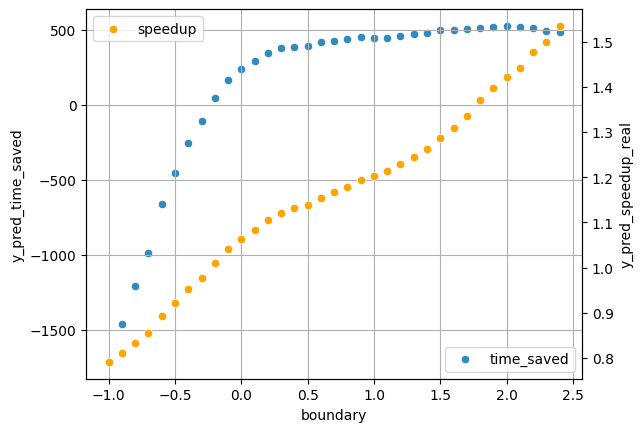

In [21]:
y_pred = (pred.materialized_times_mean - pred.times_mean)
plot_boundary((y_test.materialized_times_mean - y_test.times_mean), y_pred, upper=2.5)
res = eval_result((y_test.materialized_times_mean - y_test.times_mean), y_pred = y_pred > 0.2, full_dataset=test, target_col='time_saved')
# estimator_results['STAT.8'] = res[0]

# Analysis

In [22]:
import matplotlib
colors = ['#F5F5F5', '#DAE8FC', '#D5E8D4', '#FFE6CC', '#FFF2CC','#F8CECC', '#E1D5E7']
pal = sns.color_palette([matplotlib.colors.to_rgba(x) for x in colors])
pal

[(0.9607843137254902, 0.9607843137254902, 0.9607843137254902),
 (0.8549019607843137, 0.9098039215686274, 0.9882352941176471),
 (0.8352941176470589, 0.9098039215686274, 0.8313725490196079),
 (1.0, 0.9019607843137255, 0.8),
 (1.0, 0.9490196078431372, 0.8),
 (0.9725490196078431, 0.807843137254902, 0.8),
 (0.8823529411764706, 0.8352941176470589, 0.9058823529411765)]

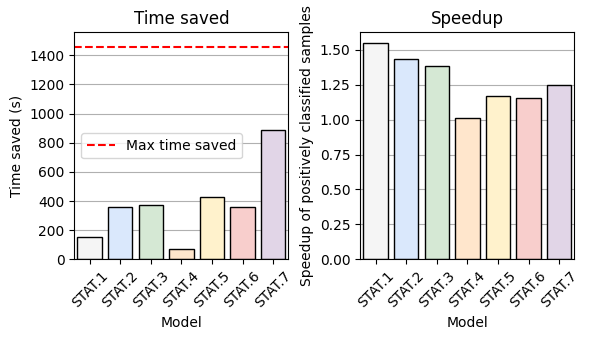

In [23]:
resdf = pd.DataFrame(estimator_results.values())
resdf['Model'] = estimator_results.keys()
resdf = resdf.merge(pd.json_normalize(resdf.speedup), left_index=True, right_index=True)
resdf['fraction_of_optimal_time_saved'] = resdf.y_pred_time_saved / resdf.y_true_time_saved
palette = []
f, axs = plt.subplots(1,2, figsize=(6,3.5))
labels = ["Time saved (s)", "Speedup of positively classified samples"]
titles = ["Time saved", "Speedup", "Performance"]
max_time_saved = resdf.y_true_time_saved.max()
max_speedup = resdf.y_pred_speedup_real.max()
for ax, var, label, title in zip(axs, ['y_pred_time_saved', 'y_pred_speedup_real'], labels, titles):
    sns.barplot(data=resdf, x='Model', y=var, ax=ax, palette=pal, saturation=1, edgecolor = "black", linewidth=1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.grid(axis='y')
    ax.set_axisbelow(True)
    ax.set_ylabel(label)
    # ax.set_xlabel("Cost Model")
    ax.set_title(title)
    if var =='y_pred_time_saved':
        ax.axhline(max_time_saved, color='red', linestyle='--', label="Max time saved")
        ax.set_ylim(top=max_time_saved+100)
        ax.legend()
    elif var == 'y_pred_time_saved':
        ax.axhline(max_time_saved, color='red', linestyle='--', label="Max speedup")
        ax.legend()
    
f.tight_layout()
# f.savefig("/home/pepijn/Documents/uni/y5/thesis/writing/overleaf/chapters/05_cost_estimation/figures/stat-models-compare.pdf", bbox_inches='tight')

In [27]:
X_validate

,selectivity,comp_scalar_dense,c_T,mem_fac_write,parallelism,mem_write_scalar_dense,comp_matrix_dense,13,mem_read_colsum,gpu_memory_bandwidth,...,operator,gpu_cache_size_l1,gpu_cache_size_l2,comp_rmm_mat,cardinality_S,mem_write_colsum,gpu_processing_power_single_precision,gpu_clock_speed_max_boost,24,morpheusfi_q
117,1.005264,62.502500,11,0.000019,None,0.000019,0.0000,0.0,0.000000,732.0,...,Linear Regression,24.0,4.0,0.0,502632,0.000000,10.60,1303.0,0.0,0
125,1.005264,125.002500,11,0.000039,None,0.000038,1000.0200,0.0,0.000000,732.0,...,Gaussian,24.0,4.0,0.0,502632,0.000000,10.60,1303.0,0.0,0
133,1.005264,375.007500,11,0.000066,None,0.000115,1162.5075,0.0,0.000058,732.0,...,KMeans,24.0,4.0,0.0,502632,0.000058,10.60,1303.0,0.0,0
141,1.005264,312.500000,11,0.000019,None,0.000096,0.0000,0.0,0.000000,732.0,...,Logistic Regression,24.0,4.0,0.0,502632,0.000000,10.60,1303.0,0.0,0
262,1.000002,61.044000,11,0.000019,None,0.000019,0.0000,0.0,0.000000,732.0,...,Linear Regression,24.0,4.0,0.0,488333,0.000000,10.60,1303.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347740,0.914657,4771.614375,5,0.000269,None,0.001468,0.0000,0.0,0.000000,900.0,...,Logistic Regression,128.0,6.2,0.0,6983028,0.000000,14.03,1370.0,0.0,0
347741,0.914657,4771.614375,5,0.000269,None,0.001468,0.0000,0.0,0.000000,616.0,...,Logistic Regression,64.0,5.5,0.0,6983028,0.000000,11.75,1545.0,0.0,0
347742,0.914657,4771.614375,5,0.000269,None,0.001468,0.0000,0.0,0.000000,696.0,...,Logistic Regression,128.0,6.0,0.0,6983028,0.000000,37.42,1740.0,0.0,0
347743,0.914657,4771.614375,5,0.000269,None,0.001468,0.0000,0.0,0.000000,484.0,...,Logistic Regression,48.0,2.8,0.0,6983028,0.000000,10.61,1582.0,0.0,0


In [30]:
y_true = y_validate
y_pred = predict_linreg_ensemble(stat7, validate, X_validate, y_validate.columns, split_by=['operator', 'compute_type'])

2024-03-24 21:45:52.042 | INFO     | src.analytical_model:predict_linreg_ensemble:71 - Predicting results of the analytical model using a linear regression ensemble


In [32]:
y_true

,times_mean,materialized_times_mean
117,1.331066,0.639601
125,0.085030,0.026524
133,0.461269,0.315751
141,0.401411,0.236812
262,2.855978,0.630398
...,...,...
347740,2.117749,2.387363
347741,1.838746,3.122949
347742,2.465284,3.089785
347743,3.367059,4.518841


In [40]:
res

,stat_y_true_time_saved,stat_y_pred_time_saved
117,-0.691465,-7.043701e+11
125,-0.058506,-3.266536e+12
133,-0.145518,-1.629001e-01
141,-0.164600,7.673218e+12
262,-2.225580,-7.043701e+11
...,...,...
347740,0.269614,-3.542084e+00
347741,1.284202,-3.493378e+00
347742,0.624502,-3.545502e+00
347743,1.151782,-3.589691e+00


In [43]:
res = pd.DataFrame(
    {
        "stat_y_true": (y_true.materialized_times_mean - y_true.times_mean)> 0,
        "stat_y_pred": (y_pred.materialized_times_mean - y_pred.times_mean) > 0,
    }
)
res.to_csv("evaluation/predictions/stat_label.csv")